# Hyperoptによるパラメータ調整の評価関数に、
# 交差検証を用いて、結果を確認する

In [10]:
import numpy as np
from hyperopt import hp, tpe, Trials, fmin

RANDOM_SEED=71

# データの用意

In [11]:
# MNIST(手書き文字） 10ラベル,64次元
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
data = digits['data']
data = data / np.max(digits['data'])
target = digits['target']

#交差検証に利用するデータ
X = data
y = target

# 教師データ7割と試験データ3割に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.3, stratify=target, random_state=RANDOM_SEED)

# データの標準化処理
from sklearn.preprocessing import StandardScaler
## MNISTは標準化されてるので不要

### サンプルとして、無調整のSVCによる学習精度を見る

In [12]:

from sklearn.svm import SVC
svc = SVC(random_state=RANDOM_SEED)
model = svc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, recall_score
y_pred = model.predict(X_test)
print('Accuracy: %.5f' % accuracy_score(y_test,y_pred))
print('f1      : %.5f' % f1_score(y_test,y_pred, average = 'micro'))
print('recall  : %.5f' % recall_score(y_test,y_pred, average = 'micro'))


Accuracy: 0.96296
f1      : 0.96296
recall  : 0.96296


# Hyperoptによるハイパーパラメータ調整
# 前のプログラムと同じため割愛

In [13]:
# パラメータ探索空間
hyperopt_parameters = {
    # log_uniformは範囲指定(exp(uniform(low, high))のような対数に一様分布)
    'C': hp.loguniform('C', -8, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    # hp.choiceは、リストのどれか１つを選択する
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])
}

from sklearn.svm import SVC
from sklearn.metrics import f1_score
# 評価関数
# argsには、設定した探索するパラメータが渡される
def objective(args):
    # SVMによるモデルの作成と学習
    ## **argsは可変長引数、辞書に含まれる複数の要素を、それぞれの引数として渡す
    model = SVC(**args)
    model.fit(X_train, y_train)
    # 学習したモデルのF値を評価指標とする
    predicts = model.predict(X_test)
    f1 = f1_score(y_test, predicts, average='micro')
    # hyperoptは最小化を返すため、最大化を求める場合は-1をかける
    return -1*f1

# 試行回数
max_evals = 200
# 試行の過程を記録するインスタンス
trials = Trials()

# hyperopt.fmin()により、探索空間における最小の値を探索する
best = fmin(
    # 1.最小化する関数の定義
    objective,
    # 2.探索空間の設定
    hyperopt_parameters,
    # 3.どのロジックを利用するか、基本的にはtpe.suggestでOK
    algo=tpe.suggest,
    # 4.iterationする回数
    max_evals=max_evals,
    # 試行の過程を記録
    trials=trials,
    # 試行の過程を出力
    verbose=1
)

print(best)
print('ベストスコア')
print('micro_f1 : ', -1*trials.best_trial['result']['loss'])
print('C        : ', best['C'])
print('gamma    : ', best['gamma'])
print('kernel   : ', ['rbf', 'poly', 'sigmoid'][best['kernel']])

{'C': 1.431814770052726, 'gamma': 0.33822215243481935, 'kernel': 0}
ベストスコア
micro_f1 :  0.9925925925925926
C        :  1.431814770052726
gamma    :  0.33822215243481935
kernel   :  rbf


### Hyperoptを使用するための評価関数とパラメータ探索空間の設定
### 評価関数をf値から、交差検証で求めたf値に変更する

In [14]:
# パラメータ探索空間
hyperopt_parameters = {
    # log_uniformは範囲指定(exp(uniform(low, high))のような対数に一様分布)
    'C': hp.loguniform('C', -8, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    # hp.choiceは、リストのどれか１つを選択する
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid']),
    'random_state': RANDOM_SEED
}

from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import f1_score
# 評価関数
# argsには、設定した探索するパラメータが渡される
def objective(args):
    # SVMによるモデルの作成と学習
    ## **argsは可変長引数、辞書に含まれる複数の要素を、それぞれの引数として渡す
    model = SVC(**args)
    # 交差検証
    scoring = ["accuracy", "f1_macro", "recall_macro"]
    scores = cross_validate(model, X, y, scoring=scoring)
    # 学習したモデルのF値を評価指標とする
    f1 = np.mean(scores['test_f1_macro'])
    # hyperoptは最小化を返すため、最大化を求める場合は-1をかける
    return -1*f1

# Hyperoptの実行とチューニングの実施

In [15]:
# 試行回数
max_evals = 200
# 試行の過程を記録するインスタンス
trials = Trials()

# hyperopt.fmin()により、探索空間における最小の値を探索する
best = fmin(
    # 1.最小化する関数の定義
    objective,
    # 2.探索空間の設定
    hyperopt_parameters,
    # 3.どのロジックを利用するか、基本的にはtpe.suggestでOK
    algo=tpe.suggest,
    # 4.iterationする回数
    max_evals=max_evals,
    # 試行の過程を記録
    trials=trials,
    # 試行の過程を出力
    verbose=1
)

/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rd_bigdata01/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 

# 結果の確認

In [16]:
print(best)
print('ベストスコア')
print('micro_f1 : ', -1*trials.best_trial['result']['loss'])
print('C        : ', best['C'])
print('gamma    : ', best['gamma'])
print('kernel   : ', ['rbf', 'poly', 'sigmoid'][best['kernel']])

{'C': 6.091037974353175, 'gamma': 0.24643211797750214, 'kernel': 0}
ベストスコア
micro_f1 :  0.9760942992801911
C        :  6.091037974353175
gamma    :  0.24643211797750214
kernel   :  rbf


f値をそのまま評価関数に用いた結果  
{'C': 6.0670336160074685, 'gamma': 0.284347383436973, 'kernel': 0}  
micro_f1 :  0.9925925925925926  

交差検証を用いたf値を評価関数に用いた結果  
{'C': 6.091037974353175, 'gamma': 0.24643211797750214, 'kernel': 0}  
micro_f1 :  0.9760942992801911  

交差検証の方が低い結果になった

In [32]:
C=6.091037974353175
gamma=0.24643211797750214
kernel='rbf'

from sklearn.svm import SVC
svc = SVC(C=C, gamma=gamma, kernel=kernel, random_state=RANDOM_SEED)
model = svc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, recall_score
y_pred = model.predict(X_test)
print('Accuracy: %.5f' % accuracy_score(y_test,y_pred))
print('f1      : %.5f' % f1_score(y_test,y_pred, average = 'micro'))
print('recall  : %.5f' % recall_score(y_test,y_pred, average = 'micro'))



Accuracy: 0.99074
f1      : 0.99074
recall  : 0.99074


# Digitsの可視化

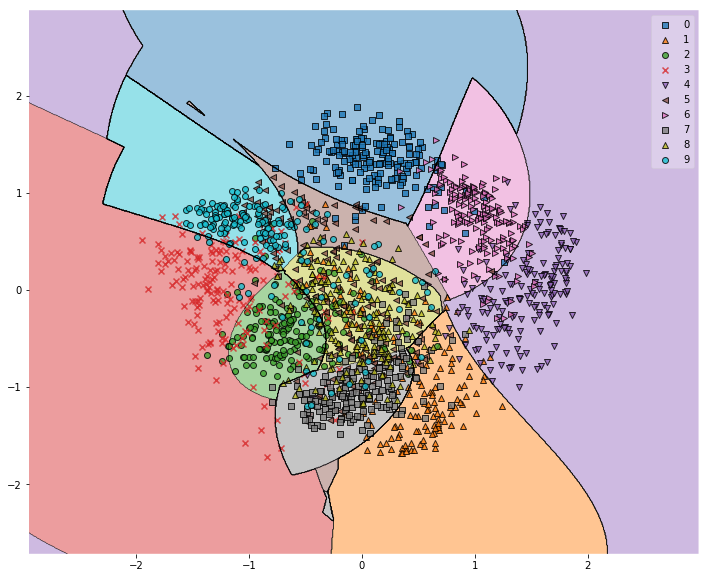

In [31]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X = data
y = target
pca.fit(X)
transformed = pca.transform(X)

# SVMのインスタンスを生成
from sklearn.svm import SVC
svc = SVC(C=C, gamma=gamma, kernel=kernel, random_state=RANDOM_SEED)
model = svc.fit(transformed, y)

from matplotlib import pyplot as plt
plt.figure(figsize=(12, 10))
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(transformed, y, clf=model,  res=0.02)